<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson2/GB_PyTorch_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [104]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import torchvision
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

Загрузка Cifar10

In [105]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)
     

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=8,
                                          shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [106]:
# print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
# print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
# print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")

# torch.cuda.empty_cache()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

В pytorch этот датасет скачивается с размерами 3, 32, 32. Для отображения нужно переставить каналы цвета в конец и перевести в numpy.

In [107]:
image, label = train_dataset[4]
print(image.size())
print(label)

torch.Size([3, 32, 32])
1


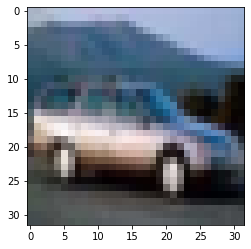

In [108]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [109]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Изначальный вариант: 4 слоя.

In [110]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [112]:
num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/1]. Step [1/782]. Loss: 0.036
Epoch [1/1]. Step [301/782]. Loss: 0.036
Epoch [1/1]. Step [601/782]. Loss: 0.035
Training is finished!


In [113]:
data_iter = iter(test_loader)
# images, labels = data_iter.next()
images, labels = next(data_iter)

In [114]:
net.eval()
outputs = net(images)

_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['plane' 'ship' 'ship' 'ship' 'dog' 'dog' 'dog' 'dog']
Accuracy is 0.25


## Зависимость от количества эпох

In [115]:
res_dict={}

optimizer.zero_grad()

def training(n_epochs=5, visual=False):
  num_epochs = n_epochs

  for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    print(f'Epoch {epoch} started')

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # # выводим статистику о процессе обучения
        # running_loss += loss.item()
        # running_items += len(labels)
        # if i % 300 == 0:    # печатаем каждые 300 mini-batches
        #     print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
        #           f'Step [{i + 1}/{len(train_loader)}]. ' \
        #           f'Loss: {running_loss / running_items:.3f}')
        #     running_loss, running_items = 0.0, 0.0
        
    data_iter = iter(test_loader)
    # images, labels = data_iter.next()
    images, labels = next(data_iter)

    net.eval()
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)
    gt = np.array([classes[labels[j]] for j in range(len(labels))])
    pred = np.array([classes[predicted[j]] for j in range(len(labels))])

    if visual:
      print(gt)
      print(pred)
    print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
    print('---------------')

    res_dict[epoch] = ((gt == pred).sum() / len(gt))
  print('---------------')
  print('Training is finished!')  

In [116]:
training(20, visual=True)

Epoch 0 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'dog' 'frog' 'dog' 'frog']
Accuracy is 0.5
---------------
Epoch 1 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'truck' 'ship' 'ship' 'dog' 'frog' 'dog' 'deer']
Accuracy is 0.25
---------------
Epoch 2 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.375
---------------
Epoch 3 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'truck' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.25
---------------
Epoch 4 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'bird' 'frog' 'dog' 'bird']
Accuracy is 0.375
---------------
Epoch 5 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'ship' 'ship' 'deer' 'frog' 'cat' 'deer']
Accuracy is 0.5
---------------
Epoch 6 started
['cat' 'ship

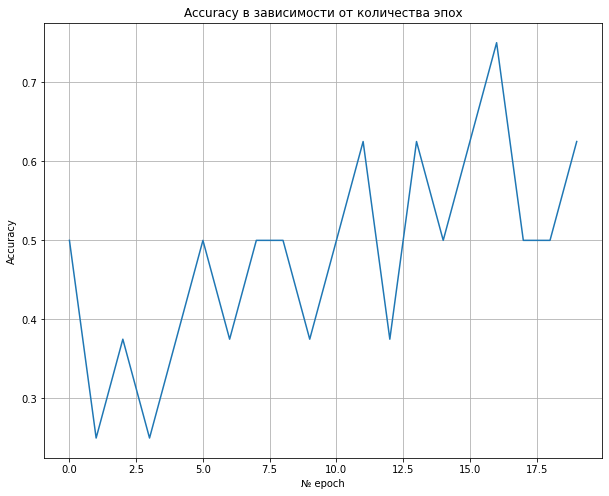

In [117]:
names = list(res_dict.keys())
values = list(res_dict.values())

# x = np.linspace(1, 20, 20)

plt.figure(figsize=(10, 8))
plt.plot(range(len(res_dict)), values)
# plt.scatter(x, values)
plt.grid()
plt.xlabel('№ epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy в зависимости от количества эпох')
plt.show()

В зависимости от эпохи мы можем получить значения как лучше, так и хуже требуемых 0,625 по accuracy. Даже с изначальной моделью.

## Зависимость от lr

In [118]:
lst_lr = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]

In [119]:
num_epochs = 6
res_dict_lr={}

optimizer.zero_grad()

for lear in lst_lr:
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lear, momentum=0.0)

  print(f'Learning rate - {lear}')

  for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # # выводим статистику о процессе обучения
        # running_loss += loss.item()
        # running_items += len(labels)
        # if i % 300 == 0:    # печатаем каждые 300 mini-batches
        #     print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
        #           f'Step [{i + 1}/{len(train_loader)}]. ' \
        #           f'Loss: {running_loss / running_items:.3f}')
        #     running_loss, running_items = 0.0, 0.0

  data_iter = iter(test_loader)
  # images, labels = data_iter.next()
  images, labels = next(data_iter)
  
  net.eval()
  outputs = net(images)

  _, predicted = torch.max(outputs, 1)
  gt = np.array([classes[labels[j]] for j in range(len(labels))])
  pred = np.array([classes[predicted[j]] for j in range(len(labels))])

  print(gt)
  print(pred)
  print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
  print('---------------')

  res_dict_lr[lear] = ((gt == pred).sum() / len(gt))
  # print('---------------')
print('Training is finished!')  

Learning rate - 0.1
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'deer' 'frog' 'dog' 'frog']
Accuracy is 0.5
---------------
Learning rate - 0.01
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.625
---------------
Learning rate - 0.001
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.625
---------------
Learning rate - 0.0001
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.625
---------------
Learning rate - 1e-05
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.625
---------------
Learning rate - 1e-06
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.

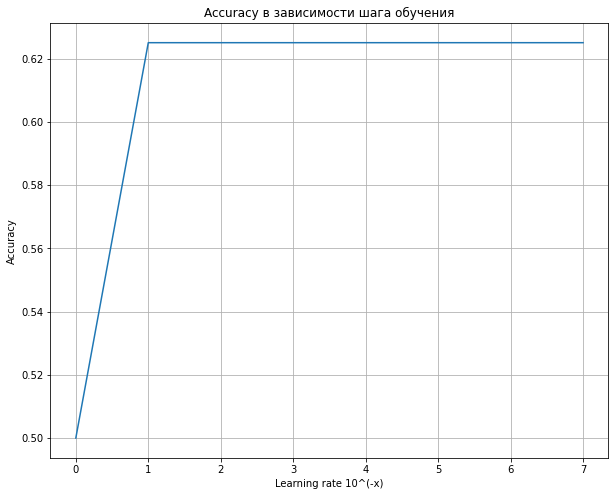

In [120]:
names = list(res_dict_lr.keys())
values = list(res_dict_lr.values())

# x = np.linspace(1, 20, 20)

plt.figure(figsize=(10, 8))
plt.plot(range(len(res_dict_lr)), values)
# plt.scatter(x, values)
plt.grid()
plt.xlabel('Learning rate 10^(-x)')
plt.ylabel('Accuracy')
plt.title('Accuracy в зависимости шага обучения')
plt.show()

In [ ]:
names

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08]

С уменьшением шага растёт точность предсказаний, но при этом выходит на насыщение. Лучшим значением оказался 0,0001

## Зависимость от оптимизатора

In [130]:
# optimiz = ['SGD', 'Adagrad', 'Nadam']

In [136]:
# optimiz[0].replace('"', '')

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.0)

In [147]:
res_dict={}

optimizer.zero_grad()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    print(f'Epoch {epoch} started')

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # # выводим статистику о процессе обучения
        # running_loss += loss.item()
        # running_items += len(labels)
        # if i % 300 == 0:    # печатаем каждые 300 mini-batches
        #     print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
        #           f'Step [{i + 1}/{len(train_loader)}]. ' \
        #           f'Loss: {running_loss / running_items:.3f}')
        #     running_loss, running_items = 0.0, 0.0
        
    data_iter = iter(test_loader)
    # images, labels = data_iter.next()
    images, labels = next(data_iter)

    net.eval()
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)
    gt = np.array([classes[labels[j]] for j in range(len(labels))])
    pred = np.array([classes[predicted[j]] for j in range(len(labels))])

   
    print(gt)
    print(pred)
    print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
    print('---------------')

print('---------------')
print('Training is finished!')  

Epoch 0 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'frog' 'frog' 'cat' 'frog']
Accuracy is 0.75
---------------
Epoch 1 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'frog' 'frog' 'cat' 'frog']
Accuracy is 0.75
---------------
Epoch 2 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'frog' 'frog' 'cat' 'frog']
Accuracy is 0.75
---------------
Epoch 3 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'frog' 'frog' 'cat' 'frog']
Accuracy is 0.75
---------------
Epoch 4 started
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'plane' 'plane' 'frog' 'frog' 'cat' 'frog']
Accuracy is 0.75
---------------
---------------
Training is finished!


Adagrad

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.0001)

In [149]:
optimizer.zero_grad()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    print(f'Epoch {epoch} started')

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()
                
    data_iter = iter(test_loader)
    # images, labels = data_iter.next()
    images, labels = next(data_iter)

    net.eval()
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)
    gt = np.array([classes[labels[j]] for j in range(len(labels))])
    pred = np.array([classes[predicted[j]] for j in range(len(labels))])

    print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
    print('---------------')

print('---------------')
print('Training is finished!')  

Epoch 0 started
Accuracy is 0.75
---------------
Epoch 1 started
Accuracy is 0.75
---------------
Epoch 2 started
Accuracy is 0.625
---------------
Epoch 3 started
Accuracy is 0.75
---------------
Epoch 4 started
Accuracy is 0.75
---------------
---------------
Training is finished!


Nadam

In [150]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(net.parameters(), lr=0.0001)

In [151]:
optimizer.zero_grad()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    print(f'Epoch {epoch} started')

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()
                
    data_iter = iter(test_loader)
    # images, labels = data_iter.next()
    images, labels = next(data_iter)

    net.eval()
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)
    gt = np.array([classes[labels[j]] for j in range(len(labels))])
    pred = np.array([classes[predicted[j]] for j in range(len(labels))])

    print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
    print('---------------')

print('---------------')
print('Training is finished!')  

Epoch 0 started
Accuracy is 0.75
---------------
Epoch 1 started
Accuracy is 0.5
---------------
Epoch 2 started
Accuracy is 0.5
---------------
Epoch 3 started
Accuracy is 0.625
---------------
Epoch 4 started
Accuracy is 0.75
---------------
---------------
Training is finished!


## Добавление двух слоёв и увеличение количества нейронов.

Добавим класс perceptron. B добавим 2 слоя и в этих слоях увеличим количество нейронов в графе обучения как степень двойки.

In [64]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return torch.sigmoid(x)
        if self.activation == "elu":
            return F.elu(x)
        if self.activation == "tanh":
            return torch.tanh(x)
        raise RuntimeError

In [159]:
class Net8(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, 16 * hidden_dim, 'sigmoid')
        self.fc2 = Perceptron(16 * hidden_dim, 8 * hidden_dim, 'elu')
        self.fc3 = Perceptron(8 * hidden_dim, 4 * hidden_dim, )
        self.fc4 = Perceptron(4 * hidden_dim, 2 * hidden_dim)
        self.fc5 = Perceptron(2 * hidden_dim, hidden_dim)
        self.fc6 = Perceptron(hidden_dim, output_dim, 'elu')
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        return x

    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = F.softmax(x)
        return x

net8 = Net8(3072, 400, 10)
net8.train()

Net8(
  (fc1): Perceptron(
    (fc): Linear(in_features=3072, out_features=6400, bias=True)
  )
  (fc2): Perceptron(
    (fc): Linear(in_features=6400, out_features=3200, bias=True)
  )
  (fc3): Perceptron(
    (fc): Linear(in_features=3200, out_features=1600, bias=True)
  )
  (fc4): Perceptron(
    (fc): Linear(in_features=1600, out_features=800, bias=True)
  )
  (fc5): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (fc6): Perceptron(
    (fc): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net8.parameters(), lr=0.0001)

optimizer.zero_grad()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = ff(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/3]. Step [1/782]. Loss: 0.021
Epoch [1/3]. Step [301/782]. Loss: 0.023
Epoch [1/3]. Step [601/782]. Loss: 0.023
Epoch [2/3]. Step [1/782]. Loss: 0.022
Epoch [2/3]. Step [301/782]. Loss: 0.023
Epoch [2/3]. Step [601/782]. Loss: 0.023
Epoch [3/3]. Step [1/782]. Loss: 0.021
Epoch [3/3]. Step [301/782]. Loss: 0.023
Epoch [3/3]. Step [601/782]. Loss: 0.023
Training is finished!


In [161]:
data_iter = iter(test_loader)
# images, labels = data_iter.next()
images, labels = next(data_iter)

net8.eval()
outputs = net(images)

_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

Accuracy is 0.75


Были также проверены различные варианты функций активации. Но вообще явных тенденций к сильному улучшению - не обнаружил. Вероятно требуется более большая выборка, чем 8 элементов, чтобы проследить явное улучшение, либо показать, что где-то допущена ошибка и явных улучшений не было. 

Почему-то часто при оптимизаторе SGD модель вообще переставала обучаться. И всегда выдавала один и тот же ответ, либо вообще одно и тоже значение для всех элементов.